In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import gym
from collections import deque
import torch.nn.functional as F
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
# Define the Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims = (32,32), activation =nn.ReLU):
        super(DQN,self).__init__()

        self.input_layer = nn.Linear(input_dim,hidden_dims[0])

        self.hidden_layer = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layer.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
            self.hidden_layer.append(activation())

        self.hidden_layer = nn.Sequential(*self.hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        x= state
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x= self.output_layer(x)
        return x

In [ ]:
# Define DQN Agent with Experience Replay Buffer
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr, gamma, epsilon, epsilon_decay, buffer_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=buffer_size)
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            if state[1]<0:
              return 0
            else:
              return 2

            return np.random.choice(self.action_dim)
        q_values = self.model(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(torch.tensor(next_state, dtype=torch.float32))).item()
            target_f = self.model(torch.tensor(state, dtype=torch.float32)).detach().numpy()
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(torch.tensor(target_f), self.model(torch.tensor(state, dtype=torch.float32)))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay

In [ ]:
# Initialize environment and agent with Experience Replay Buffer
env = gym.make('MountainCar-v0',render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.9995, buffer_size=10000)

# Train the DQN agent with Experience Replay Buffer
batch_size = 32
num_episodes = 100
rewards = []
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay(batch_size)

    rewards.append(total_reward)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

Episode: 1, Total Reward: -122.0
Episode: 2, Total Reward: -118.0
Episode: 3, Total Reward: -128.0
Episode: 4, Total Reward: -122.0
Episode: 5, Total Reward: -123.0
Episode: 6, Total Reward: -200.0
Episode: 7, Total Reward: -178.0
Episode: 8, Total Reward: -130.0
Episode: 9, Total Reward: -128.0
Episode: 10, Total Reward: -129.0
Episode: 11, Total Reward: -155.0
Episode: 12, Total Reward: -200.0
Episode: 13, Total Reward: -128.0
Episode: 14, Total Reward: -181.0
Episode: 15, Total Reward: -102.0
Episode: 16, Total Reward: -165.0
Episode: 17, Total Reward: -189.0
Episode: 18, Total Reward: -132.0
Episode: 19, Total Reward: -157.0
Episode: 20, Total Reward: -160.0
Episode: 21, Total Reward: -162.0
Episode: 22, Total Reward: -152.0
Episode: 23, Total Reward: -156.0
Episode: 24, Total Reward: -119.0
Episode: 25, Total Reward: -153.0
Episode: 26, Total Reward: -158.0
Episode: 27, Total Reward: -171.0
Episode: 28, Total Reward: -124.0
Episode: 29, Total Reward: -169.0
Episode: 30, Total Rewa

Text(0, 0.5, 'Rewards')

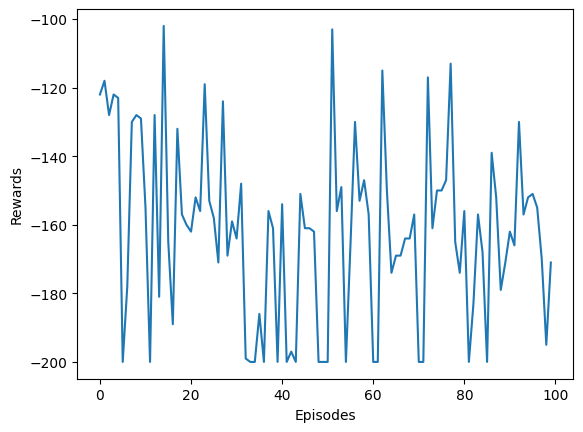

In [ ]:
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Rewards")

In [ ]:
!rm -r videos

rm: cannot remove 'videos': No such file or directory


In [ ]:
import cv2

def create_video(source, fps=60, output_name='output'):
    out = cv2.VideoWriter(output_name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (source[0].shape[1], source[0].shape[0]))
    for i in range(len(source)):
        out.write(source[i])
    out.release()

In [ ]:
import gym
import numpy as np
from gym.wrappers import RecordVideo

# Wrap the environment for recording
# env = RecordVideo(env, video_folder="videos", episode_trigger=lambda e: True)
frames = []
history = []
# Evaluate the trained agent and record video
total_rewards = []
num_episodes_eval = 1
for episode in range(num_episodes_eval):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        env.render()  # Ensure rendering is active
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        frames.append(env.render(mode="rgb_array"))
        history.append({'state':state,'action':action})
    total_rewards.append(total_reward)

env.close()
print(f"Average Total Reward (Evaluation): {np.mean(total_rewards)}")

import pandas as pd
pd.DataFrame(history)


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Average Total Reward (Evaluation): -175.0


,state,action
0,"[-0.4098057, -0.0008429222]",1
1,"[-0.41248557, -0.00267989]",0
2,"[-0.41598347, -0.0034978916]",1
3,"[-0.42027453, -0.0042910585]",1
4,"[-0.42532817, -0.0050536403]",1
...,...,...
170,"[0.4558062, 0.013265789]",2
171,"[0.46956706, 0.013760842]",2
172,"[0.48392442, 0.014357377]",2
173,"[0.49898493, 0.015060521]",2


In [ ]:
create_video(np.array(frames).reshape(-1,400,600,3), 60, 'output')


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
